# ANOVA Calibration Testing

In [25]:
################################
# LIBRARIES
################################
from functionshelper import *
from functionssessions import *

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
from pingouin import ancova
from datetime import datetime, timedelta

# Matplotlib settings
plt.style.use("seaborn")

params = {
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "axes.labelsize": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "text.usetex": False,
    "figure.figsize": [10, 5],
    "axes.grid": True,
}

plt.rcParams.update(params)
plt.close("all")

# Apply the default theme
sns.set_theme()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
### CALIBRATION AI SWEDEN
def get_timestamp(timestr, date, offset=0):
    return datetime.strptime(f'{date} {timestr}', '%Y-%m-%d %H:%M:%S') + timedelta(seconds=offset)

def add_secs(initial, secs):
    return initial + timedelta(seconds=secs)

def format_time(date, time_int):
    # convert int to str
    str_time = str(time_int)
    
    # Pad 5:00:00 to 05:00:00
    if len(str_time) < 6:
        str_time = '0' + str_time
    
    # Concatenate date and time
    str_time = date + ' ' + str_time
    
    # Convert string into date time object
    result = datetime.strptime(str_time, '%Y-%m-%d %H%M%S')
    
    return result

In [3]:
def get_calibrate_df():
    # Store all raw session dataframes in array
    calibrate_dfs = []

    # Get session files in folder
    folder = 'later-data/KalibreringAISweden/'
    session_files = sorted(os.listdir(folder))

    for i, file_name in enumerate(session_files):

        # Read individual sensor data
        raw_df = pd.read_csv(folder + '/' + file_name, skiprows=1)
        raw_df['Sensor'] = str(file_name[0])
        raw_df['Timestamp'] = raw_df['Time'].apply(lambda x: format_time('2021-12-14', x) + timedelta(hours=2))

        # Remove first 150 rows and last 30 rows
        raw_df = raw_df[150:]
        raw_df = raw_df[:-30]

        # Convert timestamp string column into datetime
        #raw_df["Timestamp"] = raw_df["Timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

        # Add to list
        calibrate_dfs.append(raw_df)

    # Combine all sensor dfs into one large dataframe
    calibrate_df = pd.concat(calibrate_dfs)
    calibrate_df.reset_index(drop=True, inplace=True)
    
    return calibrate_df

In [4]:
calibrate_df = get_calibrate_df()

### Q-Q Plots - Normality Assumption Check

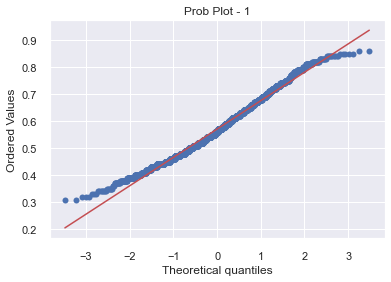

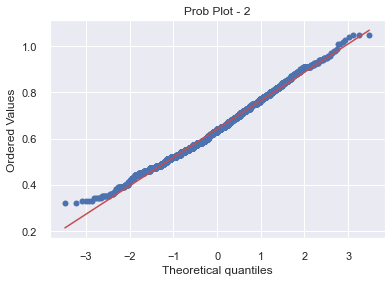

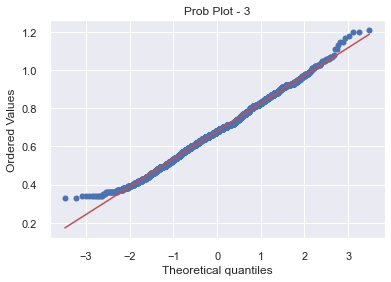

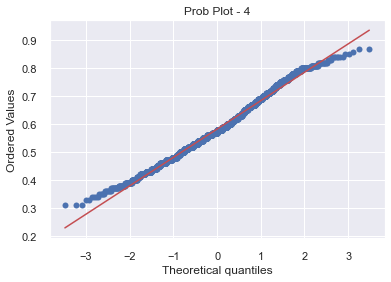

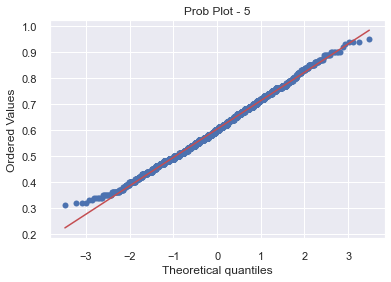

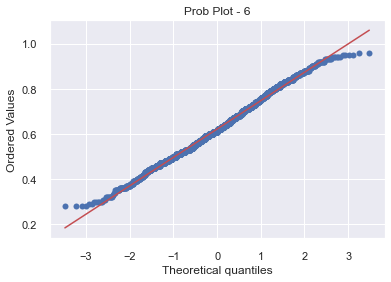

In [5]:
sample_df = calibrate_df[['Sensor', 'PM2.5']]
groups = sample_df.groupby('Sensor')

unique_sensors = sample_df['Sensor'].unique()
for sensor in unique_sensors:
    stats.probplot(sample_df[sample_df['Sensor'] == sensor]['PM2.5'], dist='norm', plot=plt)
    plt.title(f'Prob Plot - {sensor}')
    plt.show()
    
    

### Homogeneity of variance Assumption Check

In [6]:
ratio = sample_df.groupby('Sensor').std().max() / sample_df.groupby('Sensor').std().min()
ratio


PM2.5    1.43141
dtype: float64

In [7]:
# Ratio is less than 2.

### Box plots

<AxesSubplot:title={'center':'PM2.5'}, xlabel='Sensor'>

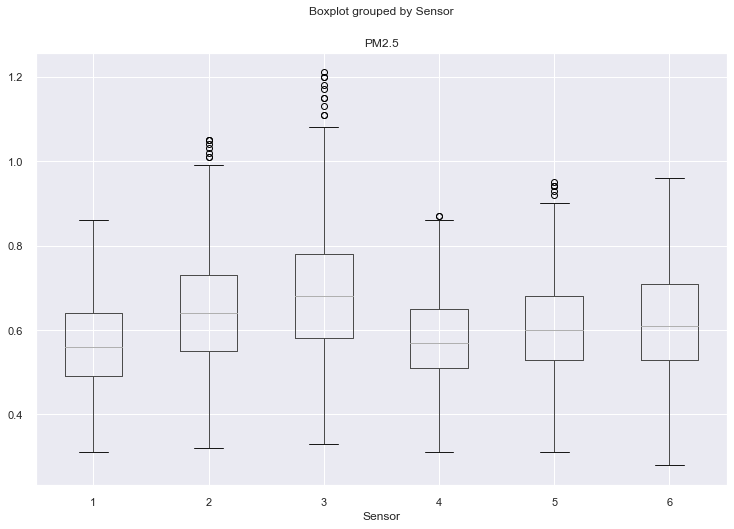

In [8]:
sample_df.boxplot('PM2.5', by='Sensor', figsize=(12, 8))

In [9]:
grps = pd.unique(sample_df.Sensor.values)
d_data = {grp:sample_df['PM2.5'][sample_df.Sensor == grp] for grp in grps}


k = len(pd.unique(sample_df.Sensor))
N = len(sample_df.values)
n = sample_df.groupby('Sensor').size()

In [10]:
grps

array(['1', '2', '3', '4', '5', '6'], dtype=object)

### Hypothesis Testing

In [11]:
sample_df.groupby('Sensor').mean()

,PM2.5
Sensor,
1,0.570914
2,0.641293
3,0.680662
4,0.582613
5,0.603684
6,0.621913


In [12]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['PM2.5'].mean()
SSTR = sample_df.groupby('Sensor').count() * (sample_df.groupby('Sensor').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['PM2.5'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('Sensor').count() - 1) * sample_df.groupby('Sensor').std()**2
anova_table['SS']['Within Groups'] = SSE['PM2.5'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['PM2.5'].sum() + SSE['PM2.5'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['Sensor'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['Sensor'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,22.893011,5,4.578602,320.307953,0.0,2.56725
Within Groups,240.631522,16834,0.014294,,,
Total,263.524533,16839,0.01565,,,


In [13]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 320.30795343759877  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 320.30795343759877  and critical value is: 2.567250044226805
Null Hypothesis is rejected.


### KHAN ACADEMY ANOVA

#### SST - Sum of squares total
How does all sensor means vary from the grand mean?

$$SST = \sum_{i=1}^{n} (y_i - \hat y)^2 $$

Where the $\hat y$ is the grand mean, $y_i$ the sample mean, and $n$ the number of groups.

In [46]:
calibrate_df = get_calibrate_df()
sample_df = calibrate_df[['Sensor', 'PM2.5']]

sample_df = sample_df[sample_df['Sensor'].isin(['6', '2'])]

In [47]:
sample_df.Sensor.unique()

array(['2', '6'], dtype=object)

In [48]:
# SST Sum of squares total
sensor_means = sample_df.groupby('Sensor')['PM2.5'].mean()
grand_mean = sample_df['PM2.5'].mean()

SST = np.sum((sample_df['PM2.5'] - grand_mean) ** 2)
SST_df = len(sample_df) - 1

SST_variance = SST / SST_df

In [49]:
SST

87.51680945247011

#### SSW - Sum of squares within

In [50]:
# SSW - Sum of squares within - variation due to variation in group

# distance between data point and their respective mean
SSW = 0

for sensor, grp in sample_df.groupby('Sensor'):
    mean = grp['PM2.5'].mean()
    SSW += np.sum((grp['PM2.5'] - mean) ** 2)
    
SSW_df = np.sum(sample_df.groupby('Sensor')['PM2.5'].count() - 1)
SSW_variance = SSW / SSW_df

#### SSB - Sum of squares between

In [51]:
## SSB - Sum of squares between. Variation between groups.
SSB = 0

for sensor, grp in sample_df.groupby('Sensor'):
    mean = grp['PM2.5'].mean()
    records = len(grp)
    
    SSB += records * ((mean - grand_mean) ** 2)
    
SSB_df = len(sample_df['Sensor'].unique()) - 1
SSB_variance = SSB / SSB_df

In [52]:
# SST = SSW + SSB
# Total variation is the sum of how much variation WITHIN a sample and the variation BETWEEN the groups

#### Hypothesis test with F-statistics

**Null and alternative hypothesis**
- H0: sensor means are the same (does not matter which sensor) 
- H1: sensor means are NOT the same (it does matter which sensor)

Step 1: Assume H0 is correct

**F-statistic with F distribution**
$$ \text{F-statistic} = \frac{\frac{SSB}{df_{SSB}}}{\frac{SSW}{df_{SSW}}} $$

What does a large/small F-statistic mean?

*If large numerator vs denomenator* --> More variation between sensors than within a single sensors --> lead us to believe there is a difference between the means --> lower probability of null hypothesis being correct.

*If large denomenator vs numerator* --> More variation within a sample than between samples --> any differences are probably due to random fluctuations --> harder to reject null hypothesis

In [53]:
# Significant value and F statistic
alpha = 0.1
F_statistic = (SSB / SSB_df) / (SSW / SSW_df)

# F critical
F_critical = stats.f.ppf(1 - alpha, SSB_df, SSW_df)

# P-value
p_value = 1 - stats.f.cdf(F_statistic, SSB, SSW)

In [54]:
print(f'F statistic: {F_statistic}\nF critical: {F_critical}\nP-value: {p_value}')

F statistic: 33.921281344981296
F critical: 2.7064380129674124
P-value: 1.8384867990106635e-05


In [55]:
if F_statistic > F_critical:
    print('There is a significant difference. Null Hypothesis rejected.')
else:
    print('Failed to reject Null Hypothesis.')

There is a significant difference. Null Hypothesis rejected.


In [56]:
if p_value < alpha:
    print('There is a significant difference. Null Hypothesis rejected.')
else:
    print('Failed to reject Null Hypothesis.')

There is a significant difference. Null Hypothesis rejected.


#### Post-hoc ANOVA testing

In [60]:
sample_df['PM2.5']

2811     0.48
2812     0.47
2813     0.45
2814     0.45
2815     0.45
         ... 
16835    0.49
16836    0.50
16837    0.56
16838    0.59
16839    0.61
Name: PM2.5, Length: 5607, dtype: float64

In [63]:
tukey = pairwise_tukeyhsd(endog=sample_df['PM2.5'],
                          groups=sample_df['Sensor'].values,
                          alpha=0.1)

TypeError: 'numpy.float64' object is not iterable

# Repeated Measures ANOVA

### Preparation of Dataframe

In [222]:
# Get calibration data
calibrate_df = get_calibrate_df()
n_sensors = len(calibrate_df['Sensor'].unique())

# Pick out Sensor (independent), Timestamp (independent), and PM2.5 (dependent) columns
columns = calibrate_df[['Sensor', 'Timestamp', 'PM2.5']]
data = columns.copy()

# Remove duplicates
data = data.drop_duplicates()

for s in data['Sensor'].unique():
    data[data['Sensor'] == s] = data[data['Sensor'] == s].drop_duplicates(subset=['Timestamp'])

# Only keep timestamps where all sensors have given a reading
for t in columns['Timestamp'].unique():
    readings = len(columns[columns['Timestamp'] == t]['Sensor'].unique())
    
    if readings < n_sensors:
        data = data[data.Timestamp != t]
        
data = data.dropna()
data = data.reset_index(drop=True)

In [223]:
data.groupby('Sensor').count()

,Timestamp,PM2.5
Sensor,,
1,1940,1940
2,1940,1940
3,1940,1940
4,1940,1940
5,1940,1940
6,1940,1940


### Repeated measures

In [199]:
data

,Sensor,Timestamp,PM2.5
0,1,2021-12-14 14:24:11,0.57
1,1,2021-12-14 14:24:12,0.55
2,1,2021-12-14 14:24:13,0.54
3,1,2021-12-14 14:24:15,0.50
4,1,2021-12-14 14:24:16,0.49
...,...,...,...
11635,6,2021-12-14 15:13:13,0.46
11636,6,2021-12-14 15:13:14,0.45
11637,6,2021-12-14 15:13:15,0.44
11638,6,2021-12-14 15:13:17,0.47


In [225]:
result = AnovaRM(data=data, depvar='PM2.5', subject='Sensor', within=['Timestamp']).fit()

In [226]:
print(result)

                   Anova
          F Value   Num DF    Den DF  Pr > F
--------------------------------------------
Timestamp  1.1427 1939.0000 9695.0000 0.0001



### Ancova

In [280]:
data["Sensor"] = pd.to_numeric(data["Sensor"])
ancova_result = ancova(data=data, dv='PM2.5', covar='Sensor', between='Timestamp')
print(ancova_result)

      Source          SS    DF         F     p-unc       np2
0  Timestamp   30.651209  1939  1.029584  0.200683  0.170697
1     Sensor    0.057194     1  3.725116  0.053629  0.000384
2   Residual  148.913790  9699       NaN       NaN       NaN


### Help

In [231]:
calibrate_df = get_calibrate_df()

stat_df = calibrate_df.groupby('Sensor').agg({'PM2.5': ['std', 'mean', 'median', 'min', 'max']})
stat_df.head(10)

PM2.5                             
             std      mean median   min   max
Sensor                                       
1       0.105410  0.570914   0.56  0.31  0.86
2       0.123486  0.641293   0.64  0.32  1.05
3       0.145926  0.680662   0.68  0.33  1.21
4       0.101945  0.582613   0.57  0.31  0.87
5       0.109201  0.603684   0.60  0.31  0.95
6       0.125662  0.621913   0.61  0.28  0.96

In [237]:
stat_df['variance'] = stat_df['PM2.5']['std'] / stat_df['PM2.5']['mean']
stat_df

PM2.5                               variance
             std      mean median   min   max          
Sensor                                                 
1       0.105410  0.570914   0.56  0.31  0.86  0.184635
2       0.123486  0.641293   0.64  0.32  1.05  0.192558
3       0.145926  0.680662   0.68  0.33  1.21  0.214388
4       0.101945  0.582613   0.57  0.31  0.87  0.174979
5       0.109201  0.603684   0.60  0.31  0.95  0.180891
6       0.125662  0.621913   0.61  0.28  0.96  0.202056

In [255]:
stat2_df = calibrate_df.groupby('Sensor').agg({'NC2.5': ['std', 'mean', 'median', 'min', 'max']})
stat2_df['variance'] = stat2_df['NC2.5']['std'] / stat2_df['NC2.5']['mean']
stat2_df.head(10)

NC2.5                               variance
             std      mean median   min   max          
Sensor                                                 
1       0.795050  4.308951   4.24  2.33  6.47  0.184511
2       0.924852  4.799189   4.75  2.37  7.90  0.192710
3       0.972164  4.838858   4.86  2.41  8.89  0.200908
4       0.751496  4.334381   4.27  2.36  6.31  0.173380
5       0.817874  4.542020   4.52  2.37  7.08  0.180068
6       0.933438  4.608336   4.56  2.00  7.14  0.202554

### Webassign error article

In [291]:
calibrate_df = get_calibrate_df()

stat_df = calibrate_df.groupby('Sensor').agg({'PM2.5': ['mean', 'median', 'min', 'max', 'std', 'count']})
stat_df['SE'] = stat_df['PM2.5']['std'] / np.sqrt(stat_df['PM2.5']['count'])
stat_df['variance'] = stat_df['PM2.5']['std'] ** 2
stat_df['variance M'] = (stat_df['PM2.5']['std'] ** 2) / stat_df['PM2.5']['count']

In [293]:
stat_df

PM2.5                                           SE  variance  \
            mean median   min   max       std count                       
Sensor                                                                    
1       0.570914   0.56  0.31  0.86  0.105410  2811  0.001988  0.011111   
2       0.641293   0.64  0.32  1.05  0.123486  2800  0.002334  0.015249   
3       0.680662   0.68  0.33  1.21  0.145926  2810  0.002753  0.021294   
4       0.582613   0.57  0.31  0.87  0.101945  2805  0.001925  0.010393   
5       0.603684   0.60  0.31  0.95  0.109201  2807  0.002061  0.011925   
6       0.621913   0.61  0.28  0.96  0.125662  2807  0.002372  0.015791   

       variance M  
                   
Sensor             
1        0.000004  
2        0.000005  
3        0.000008  
4        0.000004  
5        0.000004  
6        0.000006

### Central limit theorem

In [372]:
clt = calibrate_df.groupby('Timestamp').agg({'PM2.5': 'mean'})

grand_mean = clt['PM2.5'].mean()
skew = stats.skew(clt['PM2.5'], bias=False)
kurtosis = stats.kurtosis(clt['PM2.5'], bias=False)

print(f'Mean: {mean}')
print(f'Skew: {skew}')
print(f'Kurtosis: {kurtosis}')

Mean: 0.6219130744567154
Skew: 0.07170218053008173
Kurtosis: -0.18703074032444755


<AxesSubplot:xlabel='PM2.5', ylabel='Count'>

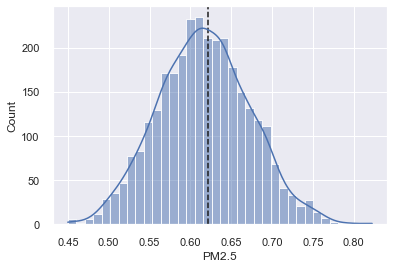

In [373]:
plt.axvline(mean, c='k', linestyle='--')
sns.histplot(clt, x='PM2.5', kde=True)

In [374]:
calibrate_df.groupby('Timestamp')['PM2.5'].head(10)

0        0.66
1        0.65
2        0.62
3        0.61
4        0.60
         ... 
16835    0.49
16836    0.50
16837    0.56
16838    0.59
16839    0.61
Name: PM2.5, Length: 16840, dtype: float64

In [381]:
# how does skew and kurtosis
y_skew = []
y_kurtosis = []
x_sample_size = np.linspace(1, len(calibrate_df.groupby('Timestamp')), 500)

In [382]:
for ss in x_sample_size:
    df = calibrate_df.groupby('Timestamp').agg({'PM2.5': 'mean'})
    y_skew.append(stats.skew(df['PM2.5'].head(int(ss)), bias=False))
    y_kurtosis.append(stats.kurtosis(df['PM2.5'].head(int(ss)), bias=False))

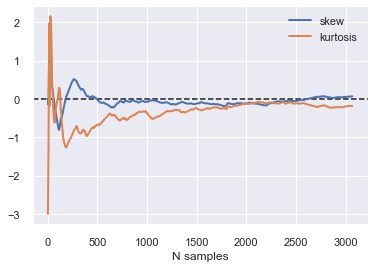

In [393]:
plt.axhline(0, c='k', linestyle='--')

plt.plot(x_sample_size, y_skew, label='skew', linewidth=2)
plt.plot(x_sample_size, y_kurtosis, label='kurtosis', linewidth=2)

plt.legend()
plt.xlabel('N samples')
plt.show()

In [371]:
print(f'Last skew: {y_skew[-1]}')
print(f'Last kurtosis: {y_kurtosis[-1]}')

Last skew: 0.07170218053008173
Last kurtosis: -0.18703074032444755


### Agreement between continuous variables

In [136]:
calibrate_df = get_calibrate_df()

In [137]:
tmp = calibrate_df[['Timestamp', 'PM2.5', 'Sensor']]
tmp[tmp['Sensor'] == '1']

,Timestamp,PM2.5,Sensor
0,2021-12-14 14:23:36,0.66,1
1,2021-12-14 14:23:37,0.65,1
2,2021-12-14 14:23:38,0.62,1
3,2021-12-14 14:23:39,0.61,1
4,2021-12-14 14:23:40,0.60,1
...,...,...,...
2806,2021-12-14 15:13:44,0.53,1
2807,2021-12-14 15:13:45,0.54,1
2808,2021-12-14 15:13:46,0.54,1
2809,2021-12-14 15:13:47,0.54,1


In [138]:
tmp.loc[tmp.Sensor == '5'].head(10)

,Timestamp,PM2.5,Sensor
11226,2021-12-14 14:24:09,0.55,5
11227,2021-12-14 14:24:10,0.53,5
11228,2021-12-14 14:24:11,0.52,5
11229,2021-12-14 14:24:12,0.52,5
11230,2021-12-14 14:24:13,0.51,5
11231,2021-12-14 14:24:14,0.51,5
11232,2021-12-14 14:24:15,0.51,5
11233,2021-12-14 14:24:16,0.50,5
11234,2021-12-14 14:24:17,0.50,5
11235,2021-12-14 14:24:19,0.50,5


In [139]:
piv = tmp.pivot_table('PM2.5', ['Timestamp'], 'Sensor')
piv.head()

Sensor,1,2,3,4,5,6
Timestamp,,,,,,
2021-12-14 14:23:09,NaN,NaN,NaN,0.55,NaN,NaN
2021-12-14 14:23:10,NaN,NaN,NaN,0.55,NaN,NaN
2021-12-14 14:23:11,NaN,NaN,NaN,0.54,NaN,NaN
2021-12-14 14:23:12,NaN,NaN,NaN,0.53,NaN,0.65
2021-12-14 14:23:13,NaN,NaN,NaN,0.52,NaN,NaN


In [215]:
"""
tmp = calibrate_df[['Timestamp', 'PM2.5', 'Sensor']]
#tmp.loc[tmp.Sensor == '5', 'Timestamp'] = tmp.loc[tmp.Sensor == '5', 'Timestamp'].apply(lambda x: x + timedelta(seconds=-55))

piv = tmp.pivot_table('PM2.5', ['Timestamp'], 'Sensor')

x_simple = np.array(piv['5'].values)
y_simple = np.array(piv['1'].values)
"
bad = ~np.logical_or(np.isnan(x_simple), np.isnan(y_simple))

x_simple = np.compress(bad, x_simple)
y_simple = np.compress(bad, y_simple)

my_rho = np.corrcoef(x_simple, y_simple)
#print(my_rho)

stats.pearsonr(x_simple, y_simple)
"""

# Get calibration data
calibrate_df = get_calibrate_df()
n_sensors = len(calibrate_df['Sensor'].unique())

# Pick out Sensor (independent), Timestamp (independent), and PM2.5 (dependent) columns
columns = calibrate_df[['Sensor', 'Timestamp', 'PM2.5']]
data = columns.copy()

# Remove duplicates
data = data.drop_duplicates()

for s in data['Sensor'].unique():
    data[data['Sensor'] == s] = data[data['Sensor'] == s].drop_duplicates(subset=['Timestamp'])

# Only keep timestamps where all sensors have given a reading
for t in columns['Timestamp'].unique():
    readings = len(columns[columns['Timestamp'] == t]['Sensor'].unique())
    
    if readings < n_sensors:
        data = data[data.Timestamp != t]
        
data = data.dropna()
data = data.reset_index(drop=True)

piv = data.pivot_table('PM2.5', ['Timestamp'], 'Sensor')

x_simple = np.array(piv['1'].values)
y_simple = np.array(piv['5'].values)

x_simple = np.mean(x_simple.reshape(-1, 20), axis=1)
y_simple = np.mean(y_simple.reshape(-1, 20), axis=1)

print(stats.pearsonr(x_simple, y_simple))


(0.12981515803637955, 0.20503844397513907)


In [210]:
print(x_simple[:10])
print(y_simple[:10])

[0.5745 0.58   0.484  0.477  0.484  0.4565 0.4415 0.639  0.6495 0.588 ]
[0.812  0.517  0.3295 0.3695 0.576  0.614  0.4875 0.6345 0.6515 0.766 ]


In [ ]:
x = np.array(piv)

In [180]:
p_df = calibrate_df[['Timestamp', 'Sensor', 'PM2.5']]

#p_df.loc[p_df.Sensor == '5', 'Timestamp'] = p_df.loc[p_df.Sensor == '5', 'Timestamp'].apply(lambda x: x + timedelta(seconds=0))
#p_df.loc[p_df.Sensor == '4'].tail(10)


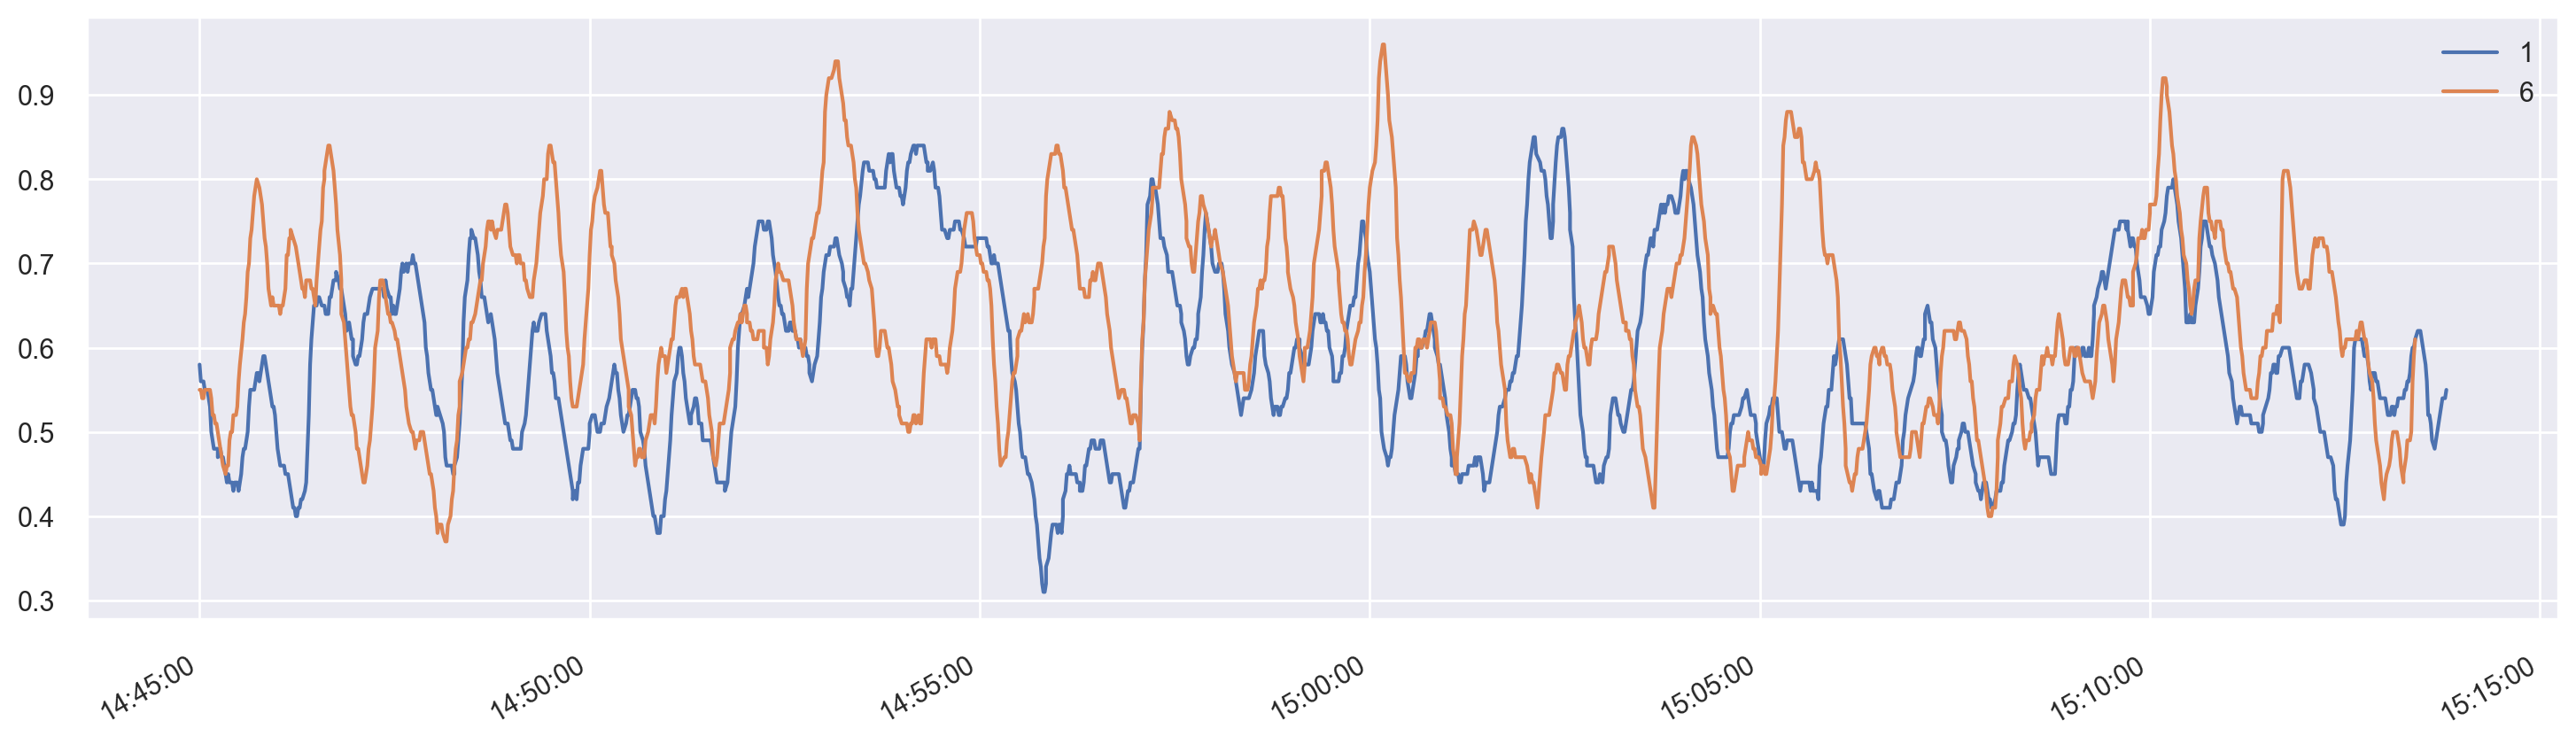

In [197]:
fig, ax = plt.subplots(figsize=[18, 5], dpi=200)


p_df = p_df.loc[(p_df.Timestamp >= '2021-12-14 14:45:00')]

for label, grp in p_df.groupby('Sensor'):
    
    if label in ['1', '6']: 
        
        if label == '5':
            ax.plot(grp['Timestamp'], grp['PM2.5'], label=label, linewidth=2)
        else:
            ax.plot(grp['Timestamp'], grp['PM2.5'], label=label)

ax.legend()        

# Format time on x-axis
plt.gcf().autofmt_xdate()
myFmt = dates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.show()

TUKEY HSD
Exclude one sensor or not
Run ANOVA on one session
Run ANOVA on Odenplan calibration for sensors 1-6, sensor A-E